In [2]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn

import warnings
warnings.filterwarnings(
    "ignore", 
    category=RuntimeWarning, 
    message="invalid value encountered in divide")

In [3]:
class FeedForwardNetwork(nn.Module):
    def __init__(self, args, in_embed_dim, o_embed_dim) -> None:
        super(FeedForwardNetwork, self).__init__()
        self.args = args
        self.MLP = nn.Sequential(
            nn.Linear(in_embed_dim, 2*in_embed_dim),
            nn.ReLU(),
            nn.Dropout(args.dropout),
            nn.Linear(2*in_embed_dim, o_embed_dim),
        )
    
    def forward(self, X):
        return self.MLP(X)
    

class LateFFN(nn.Module):
    def __init__(self, args, v_embed_dim, a_embed_dim):
        super(LateFFN, self).__init__()
        self.v_net = nn.Sequential(
            nn.LayerNorm(v_embed_dim),
            FeedForwardNetwork(args, v_embed_dim, v_embed_dim),
            nn.LayerNorm(v_embed_dim)
        )
        self.a_net = nn.Sequential(
            nn.LayerNorm(a_embed_dim),
            FeedForwardNetwork(args, a_embed_dim, a_embed_dim),
            nn.LayerNorm(a_embed_dim)
        )

    def forward(self, X_v, X_a):
        return (self.v_net(X_v), self.a_net(X_a))

class Decomposer(nn.Module):
    """
        Decomposer: Decompose the input into activities
    """
    def __init__(self, args, split_rate) -> None:
        super(Decomposer, self).__init__()
        self.args = args
        self.split_rate = split_rate

    def forward(self, input):
        if input.shape[-1] != sum(self.split_rate):
            raise ValueError("Input feature dimension does not match the sum of split_rate")
        decomposed_features = []
        current_index = 0
        for rate in self.split_rate:
            print(rate)
            feature_slice = input[..., current_index:current_index + rate]
            decomposed_features.append(feature_slice)
            current_index += rate
        return decomposed_features
    
    def get_dec_heads(self):
        return len(self.split_rate)
    

class DecomposeAttention(nn.Module):
    """
        DecomposeAttention: Decomposed Features were used as input to the attention mechanism
        - Ordinary dot product attention (v1)
        - Multi-head attention (v2)
    """
    def __init__(self, args, version, split_rate) -> None:
        super(DecomposeAttention, self).__init__()
        MODEL_MAP = {'v1': self.__dot_product, 'v2': self.__mh_attn, 'v3':self.__mh_attn}
        MODEL_MAP[version](args, split_rate)
    
    def __dot_product(self, args, split_rate):
        nheads = args['num_specific_heads']
        if nheads != 1:
            raise NotImplementedError(
                r"The current implementation only supports nheads equal to 1." 
                r"Please adjust the value of nheads accordingly."
            )
        dropout = args['dropout']
        self.attn_layers = nn.ModuleList([ # NOTE： How to parallelize the computation?
            nn.MultiheadAttention(embed_dim=dec_size, num_heads=nheads, dropout=dropout)
            for dec_size in split_rate
        ])

    def __mh_attn(self, args, split_rate):
        nheads = args['num_specific_heads']
        dropout = args['dropout']
        self.attn_layers = nn.ModuleList([ # NOTE： How to parallelize the computation?
            nn.MultiheadAttention(embed_dim=dec_size, num_heads=nhead, dropout=dropout)
            for dec_size, nhead in zip(split_rate, nheads)
        ])

    def forward(self, X):
        return torch.cat([
            attn_layer_i(query=x_i, key=x_i, value=x_i)[0] 
            for x_i, attn_layer_i in zip(X, self.attn_layers)], dim=-1)


class DecomposeEnhanceLayer(nn.Module):
    """
        DecomposeEnhanceLayer: 
    """
    def __init__(self, args, split_rate, version) -> None:
        super(DecomposeEnhanceLayer, self).__init__()
        self.args = args
        self.use_residual = args.get('residual', True)
        self.use_ffn = args.get('ffn', True)
        self.embed_dim = embed_dim = sum(split_rate)
        self.decomposer = Decomposer(args, split_rate)
        self.dec_attn   = DecomposeAttention(args['decompose_attn'], version, split_rate)
        self.layer_norm1 = nn.LayerNorm(embed_dim)
        if self.use_ffn:
            self.ffn = FeedForwardNetwork(args['decompose_ffn'], embed_dim, embed_dim)
            self.layer_norm2 = nn.LayerNorm(embed_dim)
    
    def forward(self, X):
        # Decompose Attention
        res_X = X
        dec_X = self.decomposer(X)
        dec_att_X = self.dec_attn(dec_X)
        if self.use_residual:
            H = self.layer_norm1(dec_att_X + res_X)
        else:
            H = self.layer_norm1(dec_att_X)
        
        # Feed Forward Network
        res_H = H
        if self.use_ffn:
            T = self.ffn(H)
            if self.use_residual:
                O = self.layer_norm2(T + res_H)
            else:
                O = self.layer_norm2(T)
        else:
            O = H

        return O
        


class DecomposeEnhanceBlock(nn.Module):
    """
        DecomposeEnhanceBlock:
    """
    def __init__(self, args, split_rate, version) -> None:
        super(DecomposeEnhanceBlock, self).__init__()
        self.args  = args
        num_layers = args.get('num_layers', 1)
        a_sr, v_sr = split_rate.values()
        self.v_layers = nn.Sequential(*[
            DecomposeEnhanceLayer(args, v_sr, version) 
            for _ in range(num_layers)
        ])
        self.a_layers = nn.Sequential(*[
            DecomposeEnhanceLayer(args, a_sr, version) 
            for _ in range(num_layers)
        ])

    def forward(self, X_v, X_a):
        return (self.v_layers(X_v), self.a_layers(X_a))
    
class EnhanceNet_v1(nn.Module):
    """
        EnhanceNet_v1: Using only Decomposer and DecomposeAttention(none Multi-Head version or Single-Head version)
    """
    def __init__(self, args, params) -> None:
        super(EnhanceNet_v1, self).__init__()
        split_rate   = args.get('split_rate', None)
        self.params  = params
        self.version = 'v1'

        self.v_sr   = split_rate['vision']
        self.a_sr   = split_rate['audio']

        self.v_dec  = Decomposer(args, self.v_sr)
        self.a_dec  = Decomposer(args, self.a_sr)

        self.v_dec_attn = DecomposeAttention(params, self.version, self.v_sr)
        self.a_dec_attn = DecomposeAttention(params, self.version, self.a_sr)
    
    def forward(self, vision, audio):
        split_v, split_a = self.v_dec(vision), self.a_dec(audio)
        enhanced_v, enhanced_a = self.v_dec_attn(split_v), self.a_dec_attn(split_a)
        return enhanced_v, enhanced_a

In [5]:
sims_path = r'/home/drew/Desktop/Research/MMSA/datasets/CMU-MOSI/Processed/aligned_50.pkl'
with open(sims_path, 'rb') as f:
    data = pickle.load(f)

In [6]:
train, valid, test = data.values()

In [9]:
train['text'][0], train['text_bert'][1]

(array([[-4.0177088e-02,  1.6612624e-01, -3.1079337e-01, ...,
         -7.1978465e-02,  1.8537235e-01,  1.1238687e-02],
        [-8.1925891e-02, -1.1663105e-01,  3.7471373e-02, ...,
         -2.5259398e-02,  7.4173057e-01,  5.3021461e-01],
        [ 2.0406905e-01, -8.3396442e-02,  5.6274575e-01, ...,
         -1.2614080e-01, -9.5327176e-02,  3.5403505e-01],
        ...,
        [-2.6946846e-01,  2.6557705e-01,  1.4377835e-01, ...,
          1.2469699e-01, -6.3294356e-05,  1.5201000e-02],
        [-1.5215144e-01,  3.0755949e-01,  1.4109923e-01, ...,
          1.1125209e-01,  4.3772175e-03,  3.7993062e-02],
        [-2.0817970e-01,  1.6863611e-01,  9.5248632e-02, ...,
          2.5581300e-01,  2.3596440e-02, -1.3295279e-02]], dtype=float32),
 array([[ 101, 2045, 2003, 6517, 2112,  102,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0

In [20]:
tr_vision = train['vision']
tr_audio = train['audio']
v_sample, a_sample = tr_vision[0], tr_audio[0]

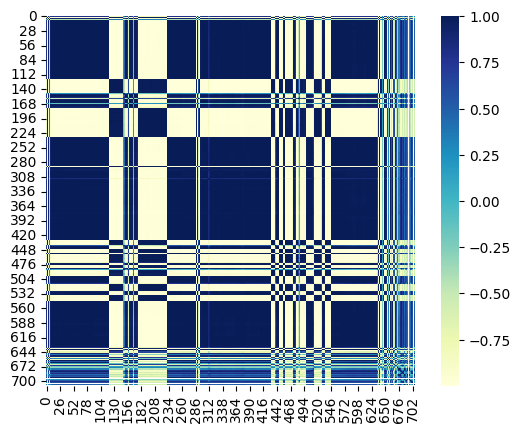

In [96]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

decomposer = Decomposer(args=None, split_rate=[288, 6, 340, 40, 35])
blocks = decomposer(v_sample)

scalers = [StandardScaler() for _ in blocks]
for i, block in enumerate(blocks):
    blocks[i] = scalers[i].fit_transform(block)
standardized_data = np.hstack(blocks)
standardized_df = pd.DataFrame(standardized_data)
correlation_matrix = standardized_df.corr()

sns.heatmap(correlation_matrix, cmap='YlGnBu', square=True, cbar=True)
plt.show()

In [1]:
class Decomposer(nn.Module):
    """
        Decomposer: Decompose the input into activities
    """
    def __init__(self, args, split_rate) -> None:
        super(Decomposer, self).__init__()
        self.args = args
        self.split_rate = split_rate

    def forward(self, input):
        if input.shape[-1] != sum(self.split_rate):
            raise ValueError("Input feature dimension does not match the sum of split_rate")
        decomposed_features = []
        current_index = 0
        for rate in self.split_rate:
            feature_slice = input.iloc[:, current_index:current_index + rate]
            decomposed_features.append(feature_slice)
            current_index += rate
        return decomposed_features
    
    def get_dec_heads(self):
        return len(self.split_rate)

def decompose_standarization_corr(df, split_rate):
    decomposer = Decomposer(args=None, split_rate=split_rate)
    blocks = decomposer(df)
    scalers = [StandardScaler() for _ in blocks]
    for i, block in enumerate(blocks):
        blocks[i] = scalers[i].fit_transform(block)
    standardized_data = np.hstack(blocks)
    standardized_df = pd.DataFrame(standardized_data)
    return standardized_df.corr(method='pearson')

def standardization_corr(df):
    scaler = StandardScaler()
    standardized_df = pd.DataFrame(scaler.fit_transform(df))
    return standardized_df.corr(method='pearson')

def get_avg_corr_dec(df_list, split_rate):
    return np.mean([decompose_standarization_corr(df, split_rate).fillna(0) for df in df_list], axis=0)

def get_avg_corr(df_list):
    return np.mean([standardization_corr(df).fillna(0) for df in df_list], axis=0)

def get_avg_corr(df_list):
    return np.mean([df.corr(method='pearson').fillna(0) for df in df_list], axis=0)

v_df_list = [pd.DataFrame(sample) for sample in tr_vision]
a_df_list = [pd.DataFrame(sample) for sample in tr_audio]

NameError: name 'nn' is not defined

In [ ]:
v_corr_dec = get_avg_corr_dec(v_df_list, [288, 6, 340, 40, 35])
a_corr_dec = get_avg_corr_dec(a_df_list, [20, 1, 12])

In [140]:
v_corr = get_avg_corr(v_df_list)
a_corr = get_avg_corr(a_df_list)

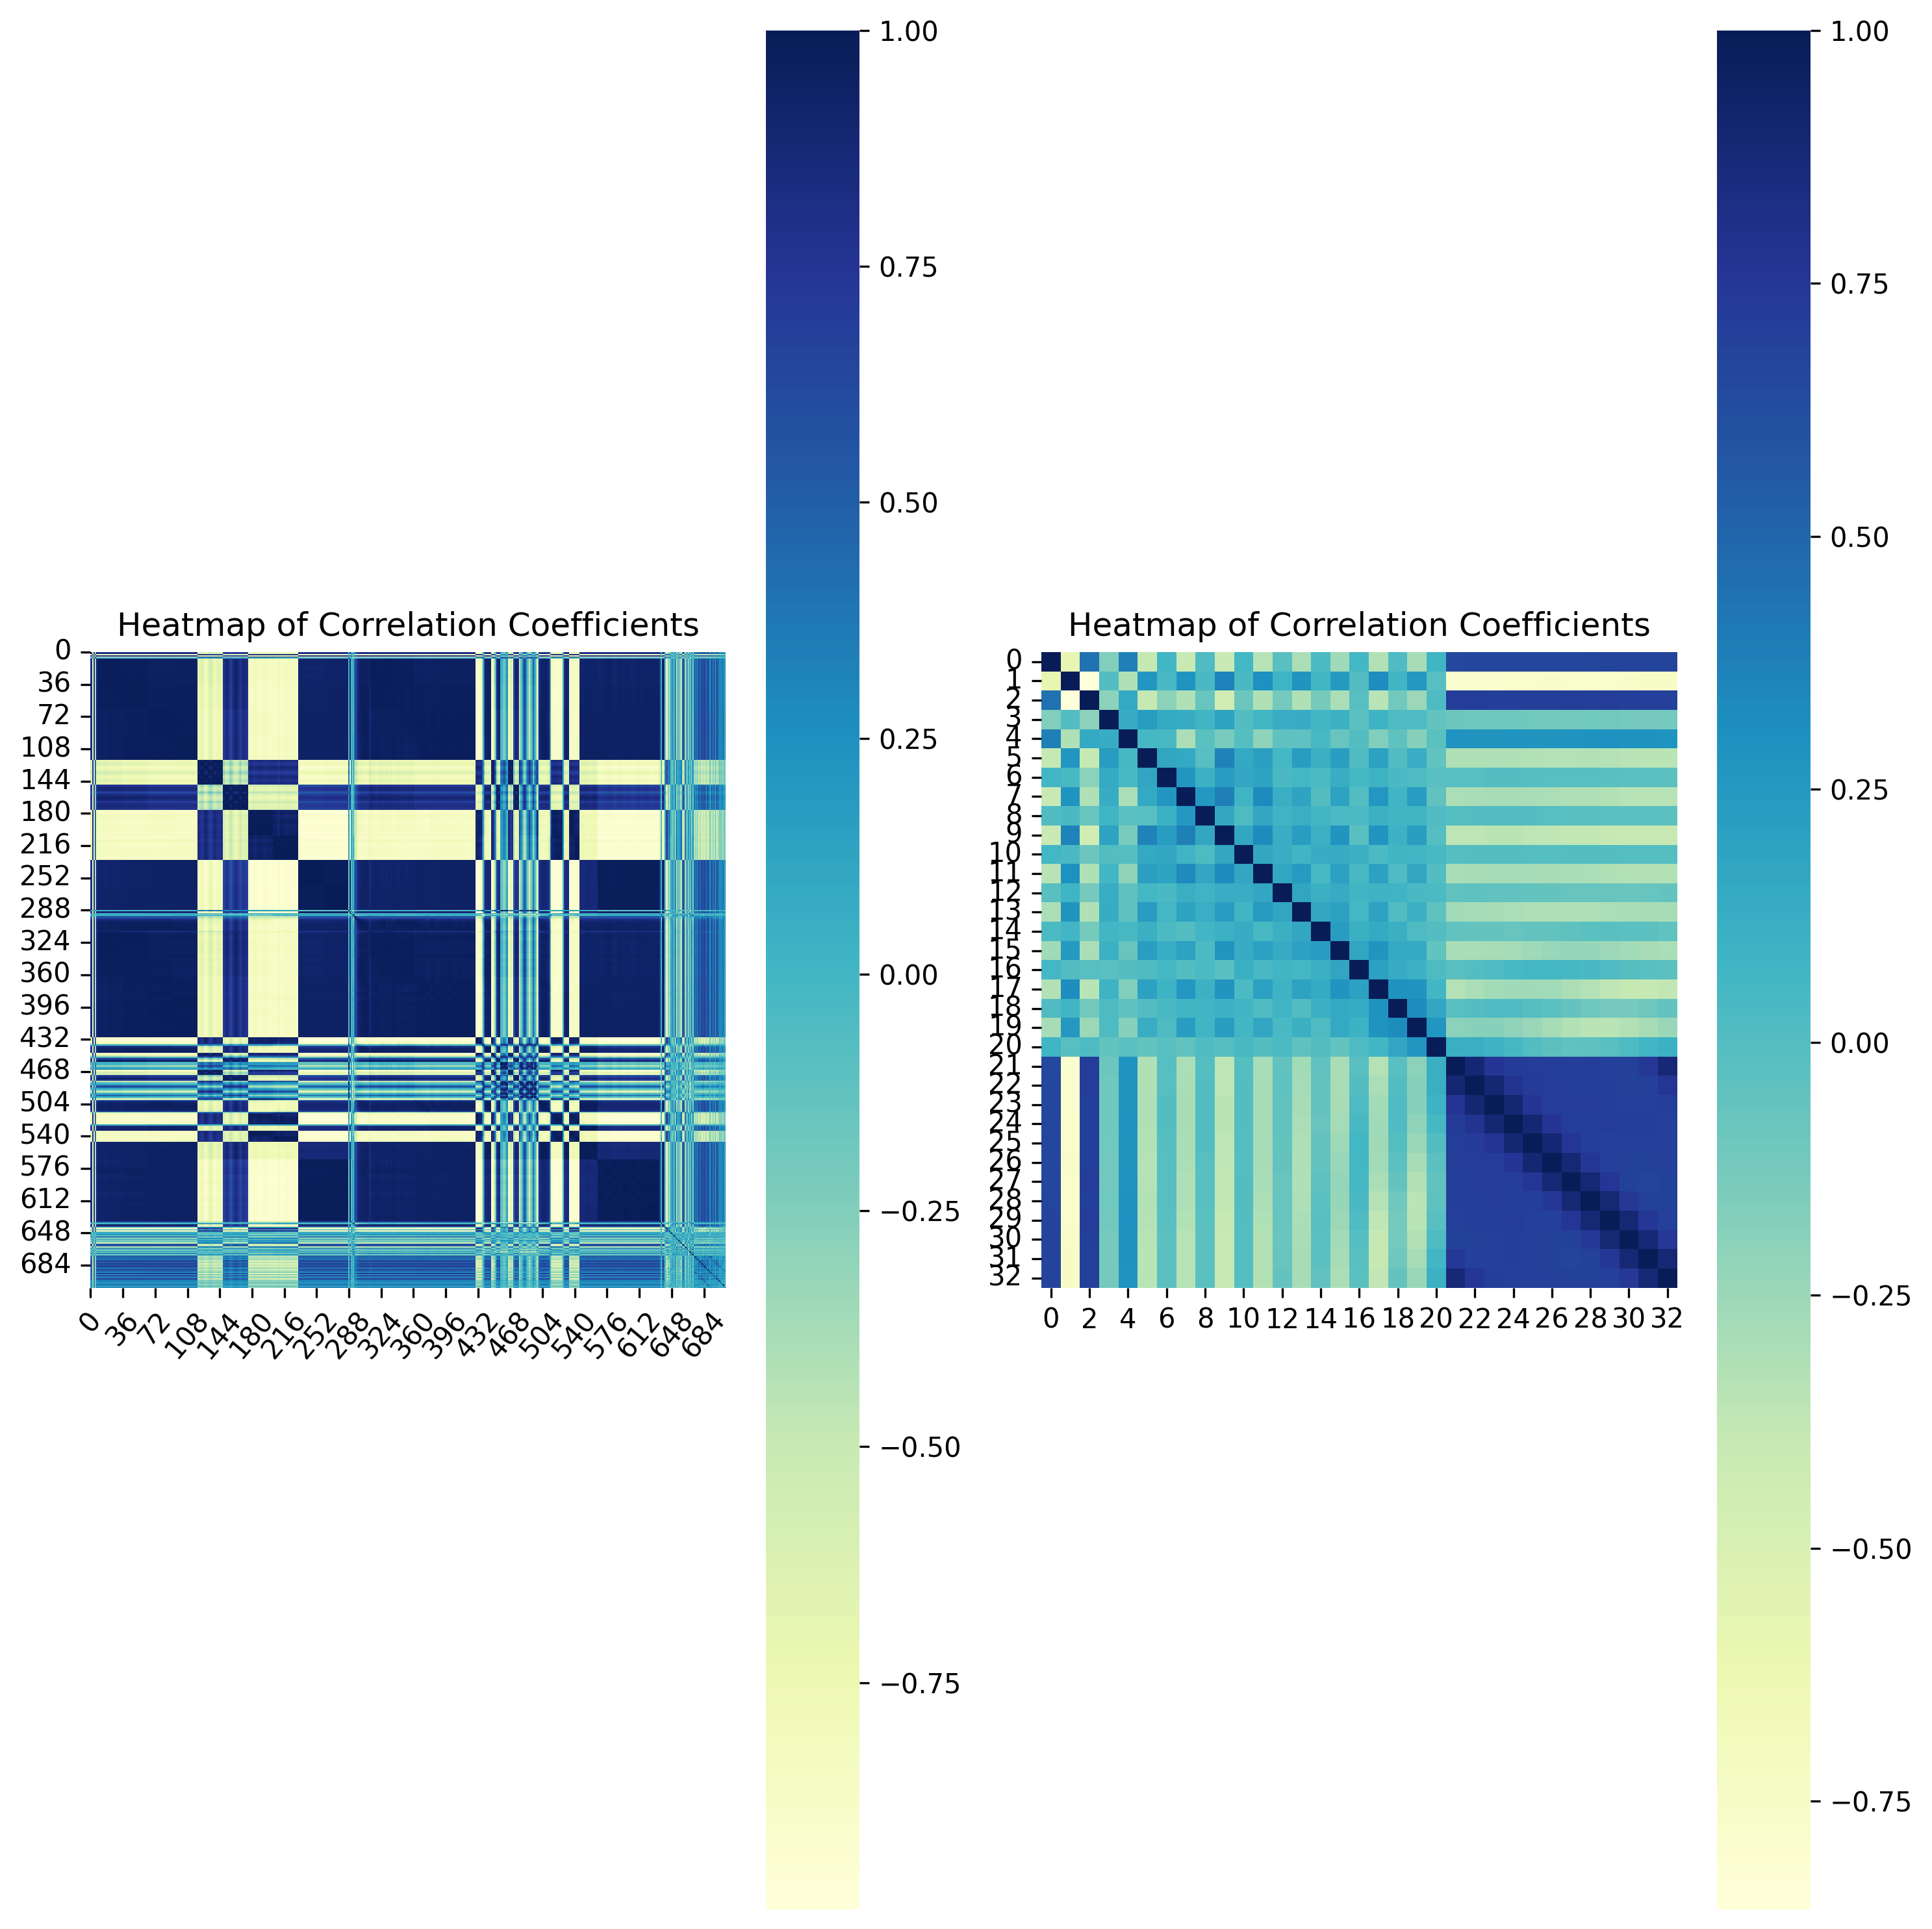

In [141]:
fig, axes = plt.subplots(1, 2, figsize=(10, 10), dpi=300)
sns.heatmap(v_corr, cmap='YlGnBu', square=True, ax=axes[0])
axes[0].set_title('Heatmap of Correlation Coefficients')
axes[0].set_yticks(np.arange(0, 709, 36))
axes[0].set_yticklabels(np.arange(0, 709, 36))
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=50)

sns.heatmap(a_corr, cmap='YlGnBu', square=True, cbar=True, ax=axes[1])
axes[1].set_title('Heatmap of Correlation Coefficients')
axes[1].set_yticklabels(axes[1].get_yticklabels())
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)
plt.tight_layout()
plt.show()

`audio`: [20, 1, 12]

`vision`: [288, 6, 340, 40, 35]

In [148]:
tr_text = train['text']
t_df_list = [pd.DataFrame(sample) for sample in tr_text]
t_corr = get_avg_corr(t_df_list)

Text(0.5, 1.0, 'Heatmap of Correlation Coefficients')

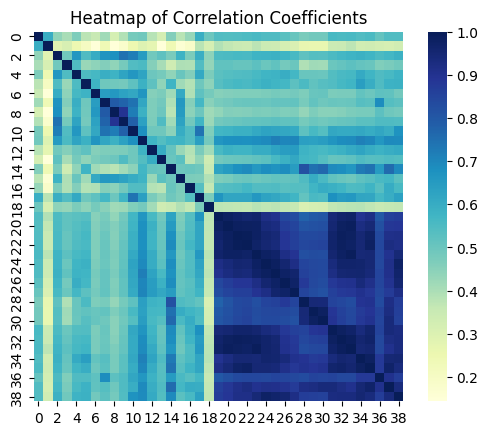

In [153]:
plt.figure()
sns.heatmap(np.corrcoef(tr_text[3]), cmap='YlGnBu', square=True)
plt.title('Heatmap of Correlation Coefficients')

In [116]:
v_df_list[0].head()

0         1         2         3         4         5       6       7    \
0  0.108899  0.065620 -0.988629  0.020134  0.066981 -0.996924  0.0650  0.0662   
1  0.108583  0.047425 -0.992195  0.020673  0.107464 -0.993737  0.0648  0.0776   
2  0.021299  0.050832 -0.996921 -0.044775  0.102752 -0.993679 -0.0118  0.0768   
3 -0.009822  0.101354 -0.994661 -0.044518  0.099010 -0.994082 -0.0274  0.1004   
4  0.041164  0.110298 -0.992802 -0.077152  0.106699 -0.989913 -0.0182  0.1090   

     8      9    ...  699  700  701  702  703  704  705  706  707  708  
0  27.86  29.10  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.8  1.0  0.0  0.0  
1  26.80  28.16  ...  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  
2  30.78  32.08  ...  0.0  0.0  0.8  0.0  0.6  0.0  0.0  1.0  0.0  0.0  
3  31.70  33.04  ...  0.0  0.6  1.0  0.8  1.0  0.0  0.0  1.0  0.0  0.0  
4  27.36  28.22  ...  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 709 columns]

In [117]:
a_df_list[0].head()

0           1           2          3          4          5   \
0  0.046387 -280.267242  123.221657  24.956572  29.312614  19.882414   
1  0.048828 -144.524612  129.652039  27.738632  35.696999  20.800335   
2  0.050781 -117.997787  133.016266  28.550879  40.158783  17.025181   
3  0.051758 -126.678650  133.965744  30.432461  40.942589   8.205548   
4  0.007812 -126.638359  132.822998  25.161295  43.898804  10.450443   

          6         7          8         9   ...        23        24  \
0  26.366991  8.287489  14.810045  5.769567  ...  0.465713  0.659590   
1  32.735088  8.748985  17.000954  3.053063  ...  0.603060  0.676370   
2  34.329132  9.143069  17.684259  0.319930  ...  0.818400  0.711364   
3  29.302601  8.056613  19.505589 -2.546790  ...  0.963131  0.706696   
4  23.518732  2.616289  20.363358 -2.653914  ...  1.000000  0.694082   

         25        26        27        28        29        30        31  \
0  0.310699  0.227585  0.032465  0.143947  0.201244  0.203948  0.192604   
1  0.322946  0.278916  0.132645  0.150062  0.202555  0.243889  0.208142   
2  0.233554  0.341312  0.265736  0.206104  0.255637  0.308404  0.215686   
3  0.164722  0.363505  0.289999  0.179740  0.192075  0.267510  0.130890   
4  0.095625  0.358740  0.283522  0.143666  0.227614  0.230331  0.045540   

         32  
0  0.072963  
1  0.154014  
2  0.198420  
3  0.174254  
4  0.141186  

[5 rows x 33 columns]

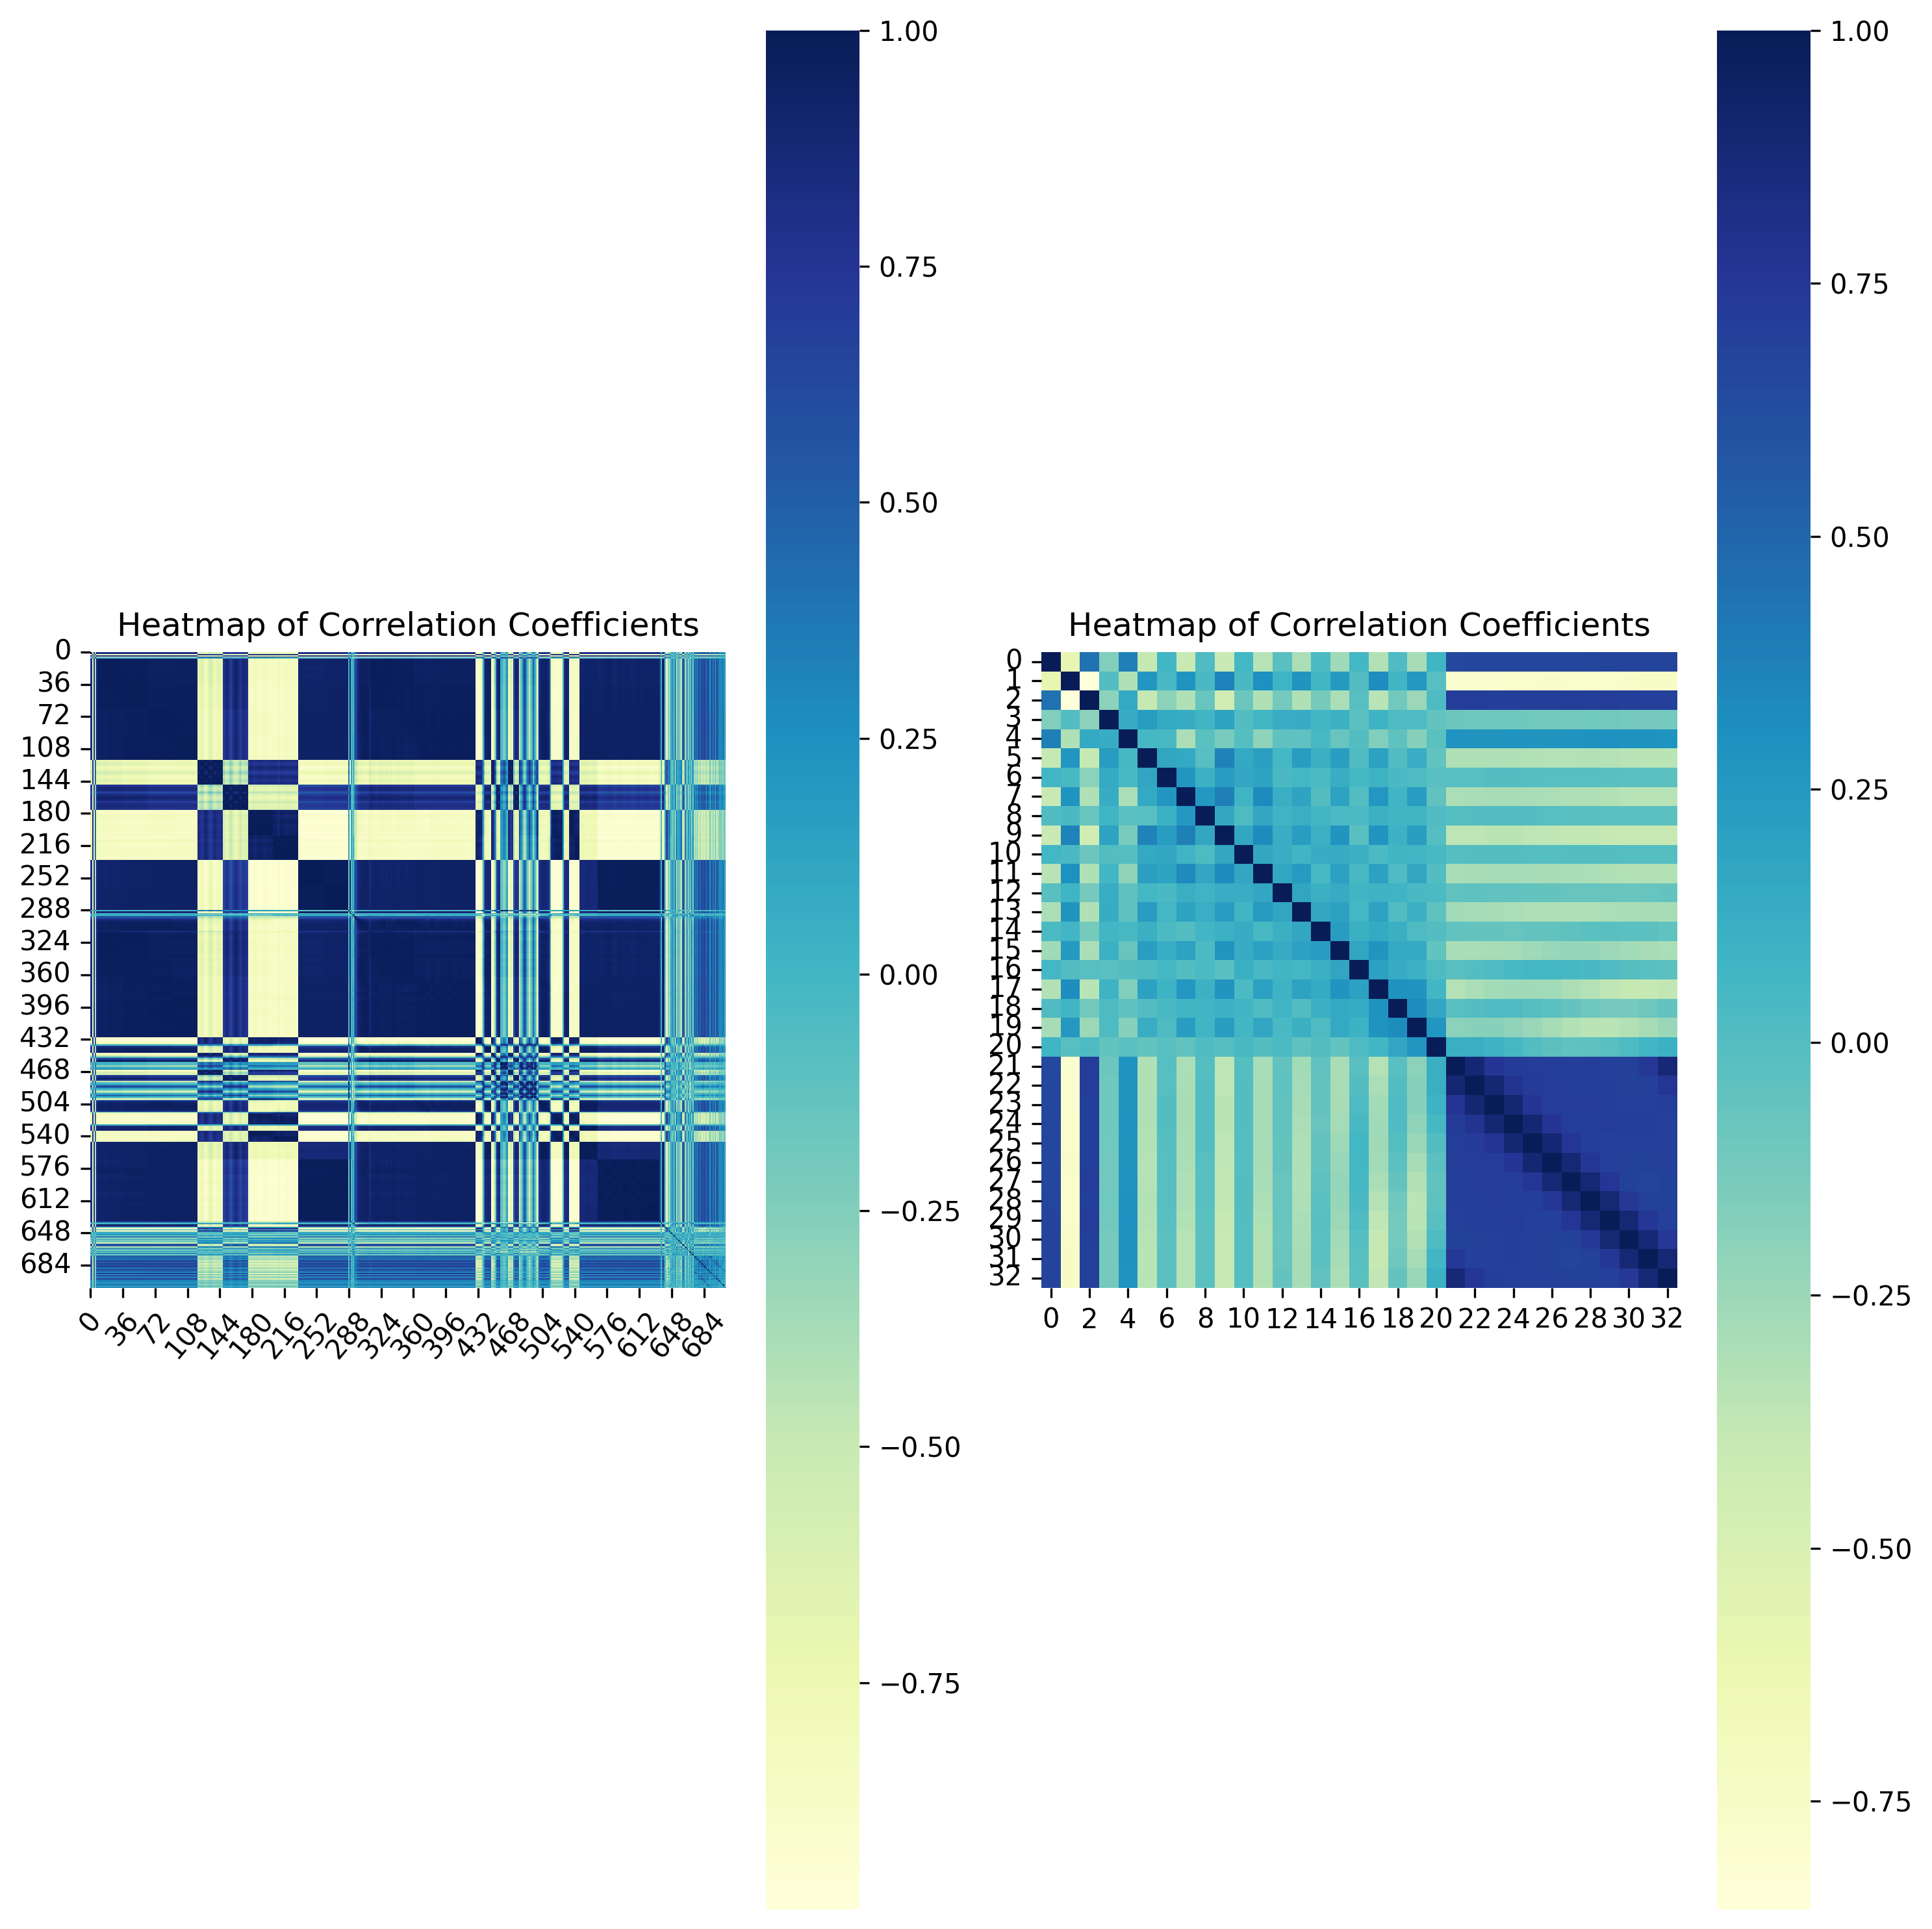

In [131]:
fig, axes = plt.subplots(1, 2, figsize=(10, 10), dpi=300)
sns.heatmap(v_corr_dec, cmap='YlGnBu', square=True, ax=axes[0])
axes[0].set_title('Heatmap of Correlation Coefficients')
axes[0].set_yticks(np.arange(0, 709, 36))
axes[0].set_yticklabels(np.arange(0, 709, 36))
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=50)

sns.heatmap(a_corr_dec, cmap='YlGnBu', square=True, cbar=True, ax=axes[1])
axes[1].set_title('Heatmap of Correlation Coefficients')
axes[1].set_yticklabels(axes[1].get_yticklabels())
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)
plt.tight_layout()
plt.show()

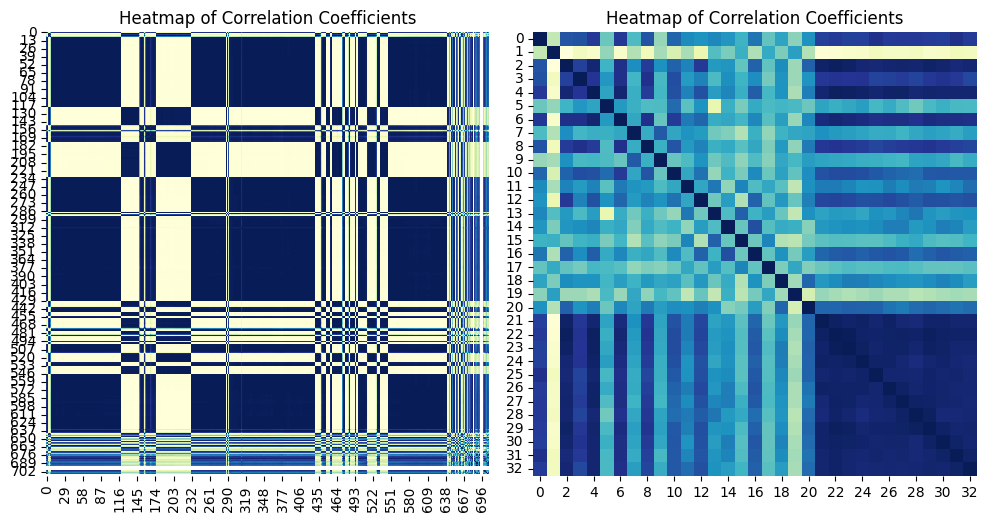

In [67]:
def corr(v_x, a_x):
    v_corr_mat = np.corrcoef(v_x, rowvar=False)
    a_corr_mat = np.corrcoef(a_x, rowvar=False)

    fig, axes = plt.subplots(1, 2, figsize=(10, 10))
    sns.heatmap(v_corr_mat, cmap='YlGnBu', square=True, cbar=False, ax=axes[0])
    axes[0].set_title('Heatmap of Correlation Coefficients')

    sns.heatmap(a_corr_mat, cmap='YlGnBu', square=True, cbar=False, ax=axes[1])
    axes[1].set_title('Heatmap of Correlation Coefficients')
    plt.tight_layout()
    plt.show()

corr(v_sample, a_sample)

8


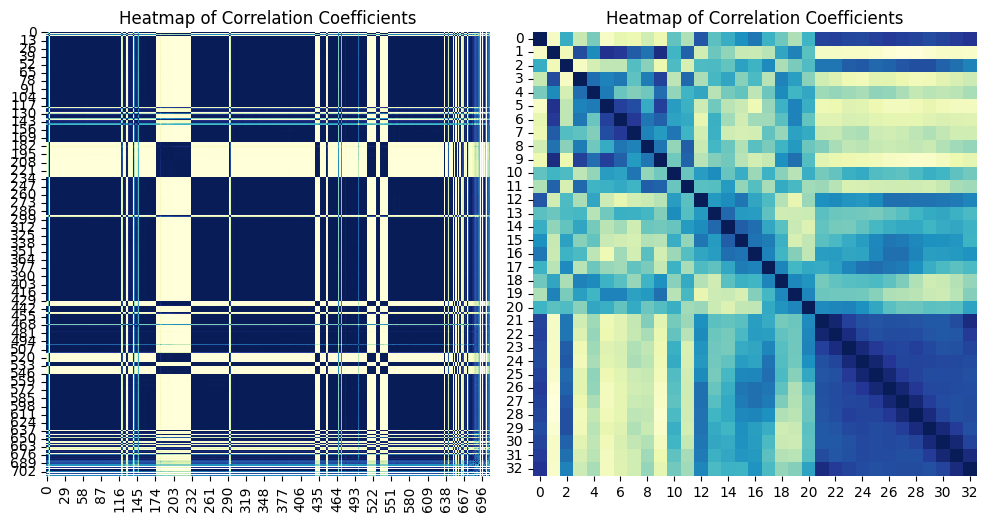

1


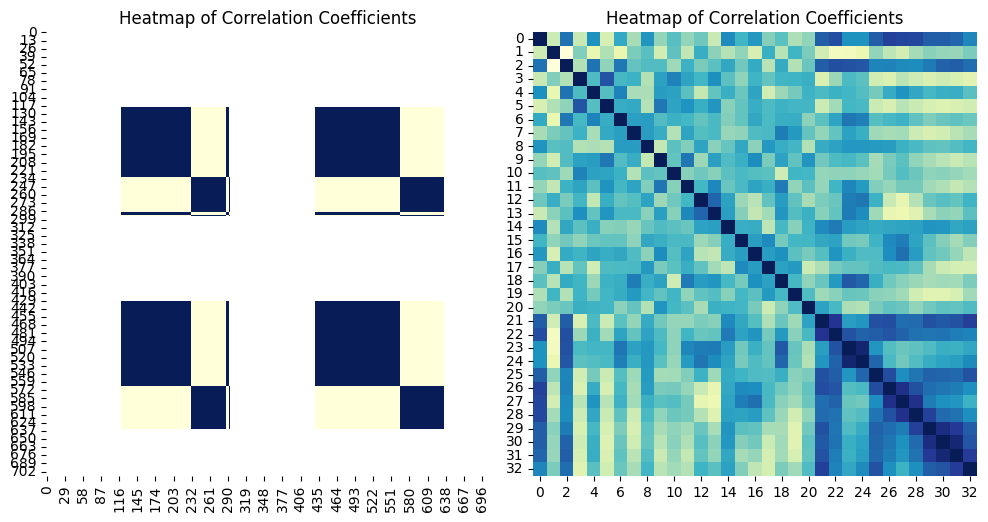

3


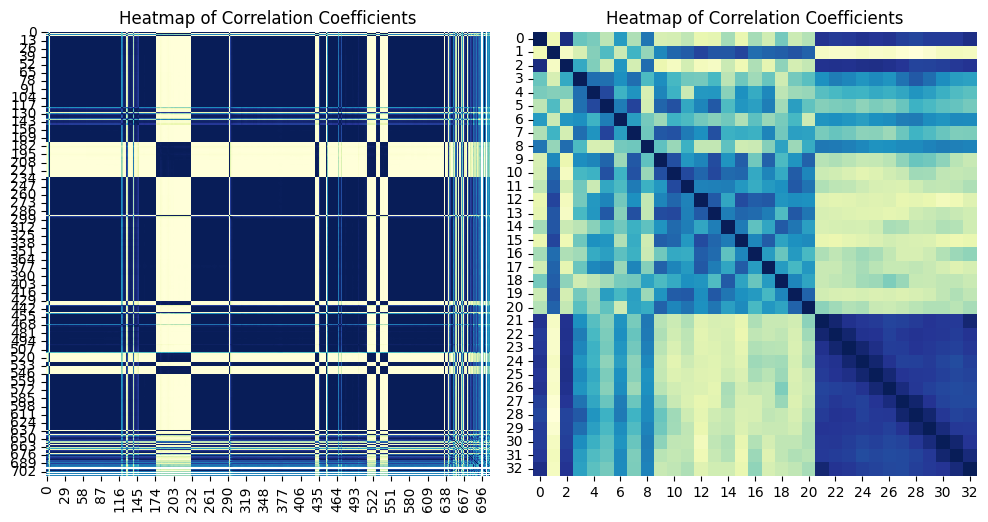

7


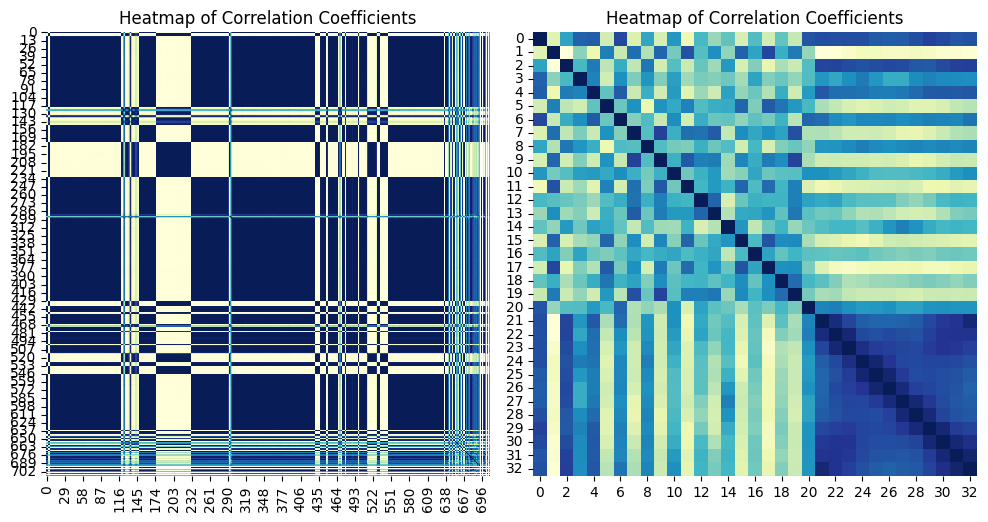

10


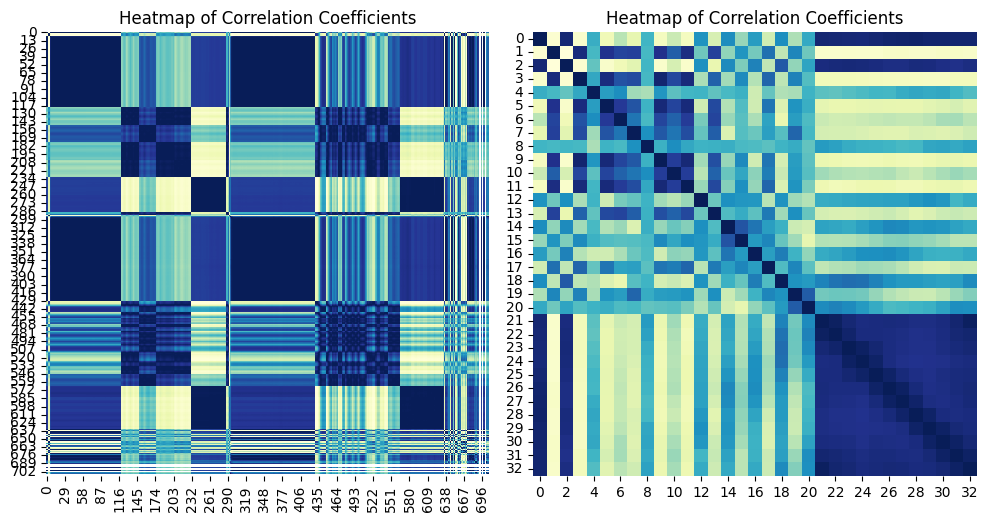

10


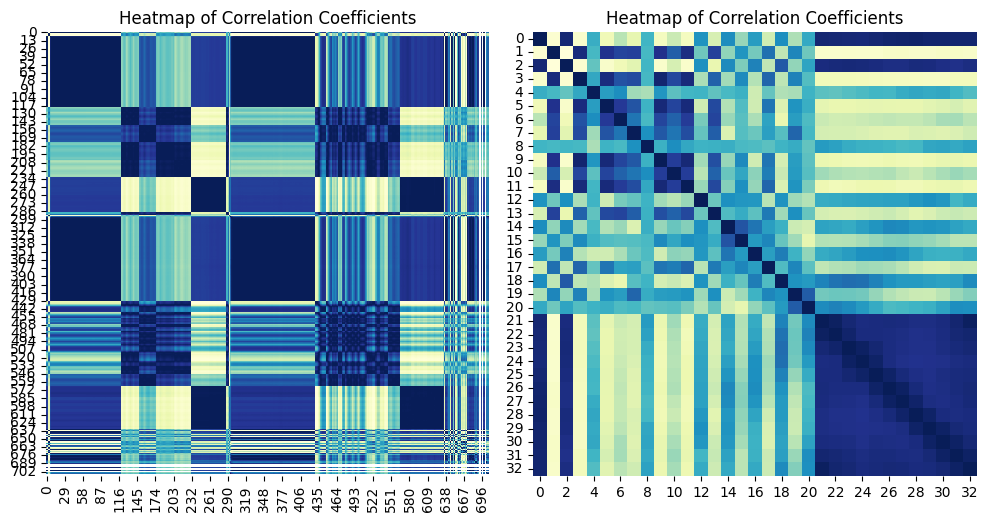

10


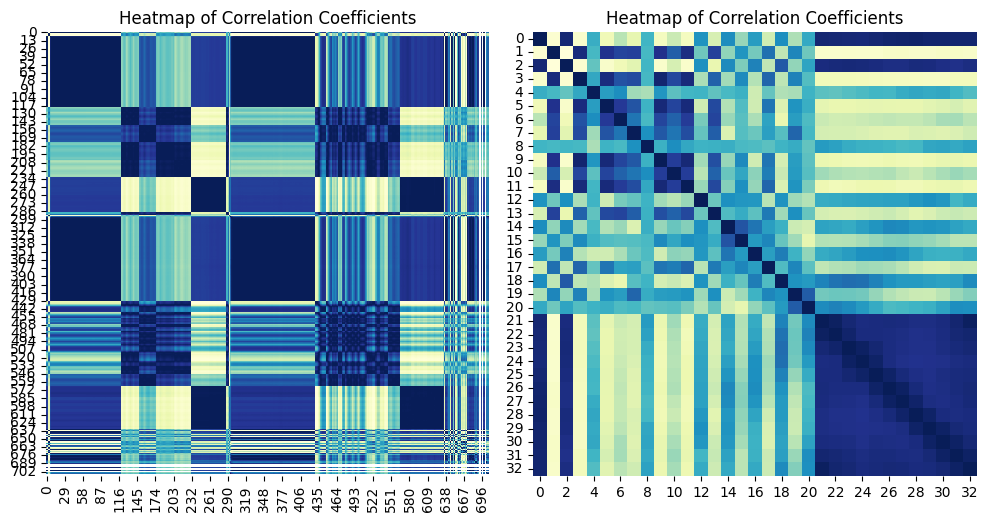

7


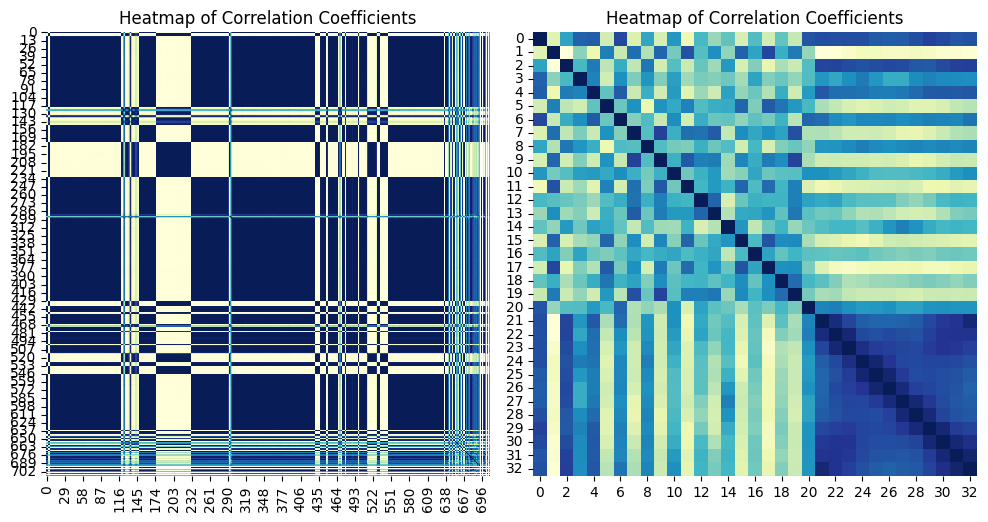

12


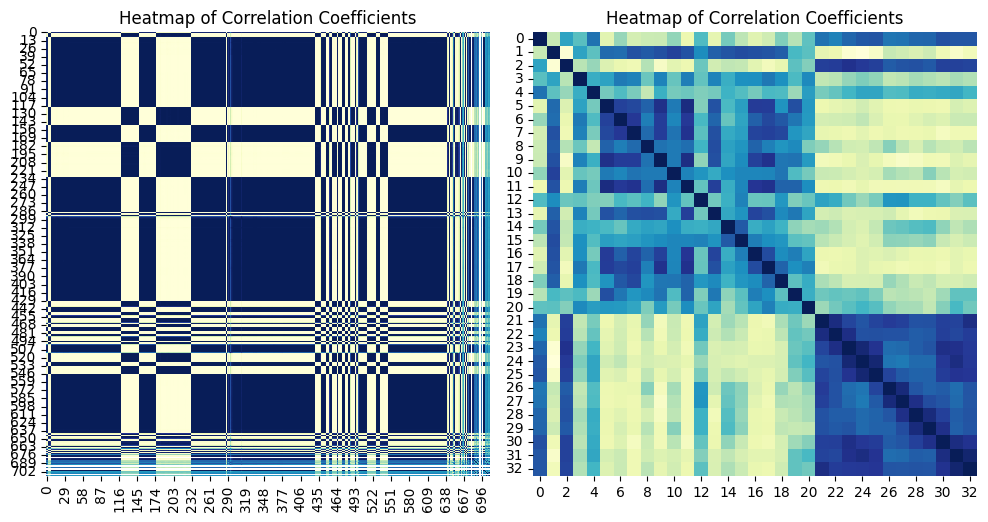

4


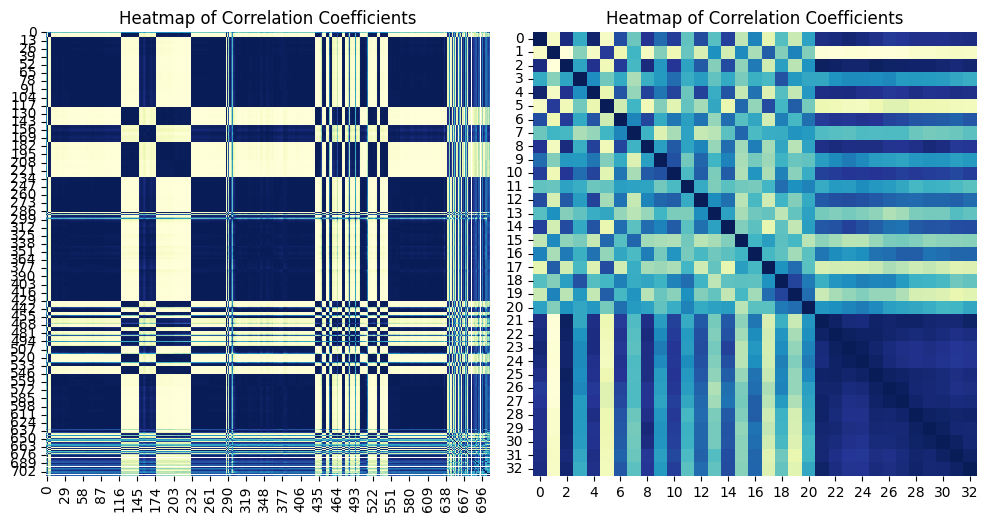

In [65]:
import random
for _ in range(10):
    idx = random.randrange(0, len(train))
    print(idx)
    corr(tr_vision[idx], tr_audio[idx])

In [51]:
params = {
    "dropout": 0.2,
    "num_specific_heads": 1
}
args = {"split_rate": {
    "audio": [20, 1, 12],
    "vision": [288, 6, 340, 40, 35]
}}

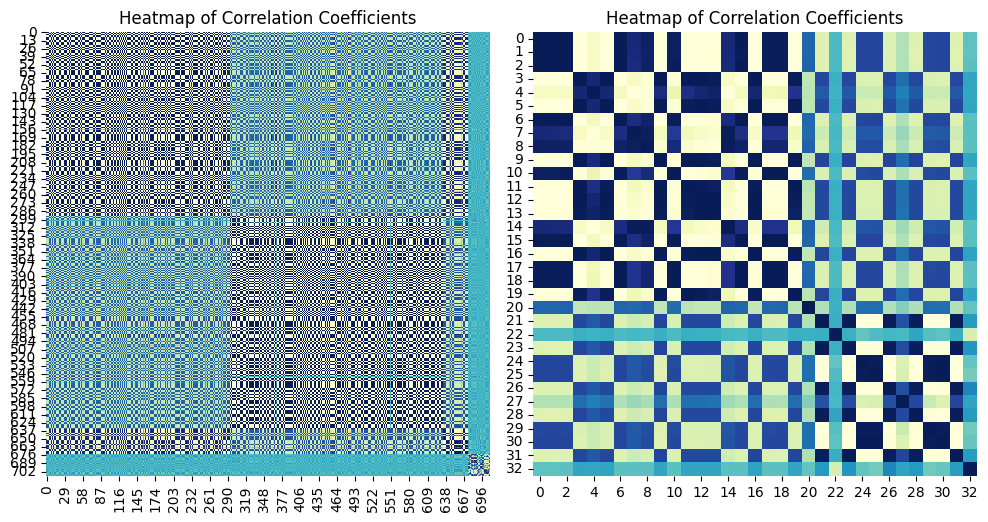

In [55]:
dec_attn = EnhanceNet_v1(args=args, params=params)

v_ts = torch.tensor(v_sample, dtype=torch.float32, requires_grad=True)
a_ts = torch.tensor(a_sample, dtype=torch.float32, requires_grad=True)

v_att_dec, a_att_dec = dec_attn(v_ts, a_ts)

corr(v_att_dec.detach().numpy(), a_att_dec.detach().numpy())

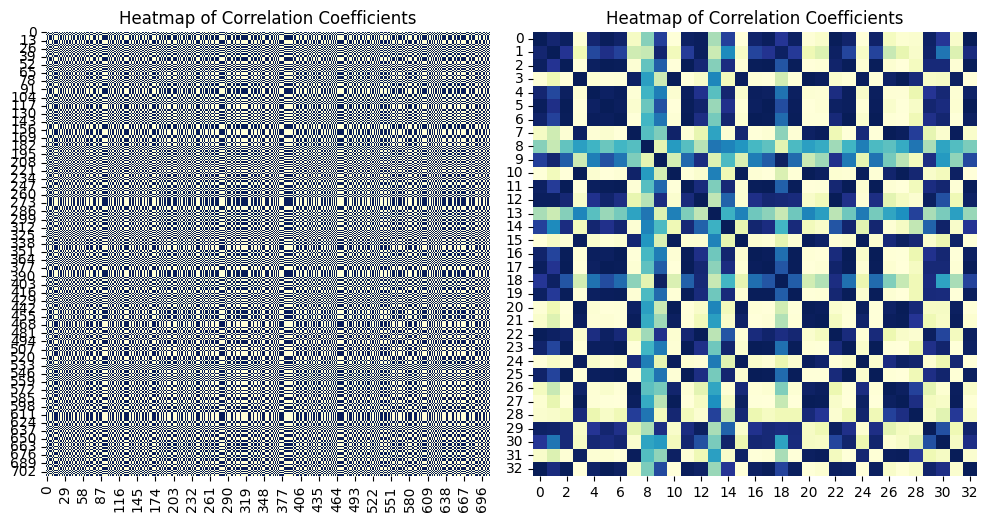

In [57]:
v_attn = nn.MultiheadAttention(embed_dim=709, num_heads=1)
a_attn = nn.MultiheadAttention(embed_dim=33, num_heads=1)

v_att_mh, a_att_mh = v_attn(v_ts, v_ts, v_ts)[0], a_attn(a_ts, a_ts, a_ts)[0]

corr(v_att_mh.detach().numpy(), a_att_mh.detach().numpy())

In [92]:
ans = v_attn(v_ts, v_ts, v_ts)

In [93]:
ans[0].shape, ans[1].shape

(torch.Size([55, 709]), torch.Size([55, 55]))

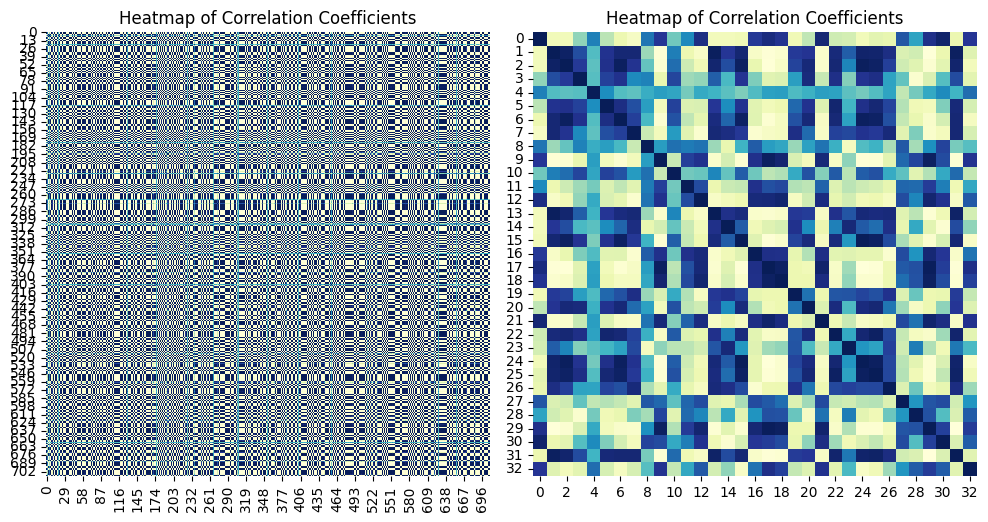

In [59]:
v_linear = nn.Linear(in_features=709, out_features=709)
a_linear = nn.Linear(in_features=33, out_features=33)

v_att_mh, a_att_mh = v_linear(v_ts), a_linear(a_ts)

corr(v_att_mh.detach().numpy(), a_att_mh.detach().numpy())

In [154]:
from rtdl_revisiting_models import LinearEmbeddings

In [167]:
embed = LinearEmbeddings(n_features=tr_vision.shape[1], d_embedding=768)
embed(torch.tensor(tr_vision[:16]).permute(0, 2, 1)).shape

torch.Size([16, 709, 55, 768])

In [169]:
torch.empty(10, 2).shape

torch.Size([10, 2])